In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%config InlineBackend.figure_format='svg'

A shape: (512, 512)
W shape: (101, 423)
True
generate aw shape: (512, 512)
True
True


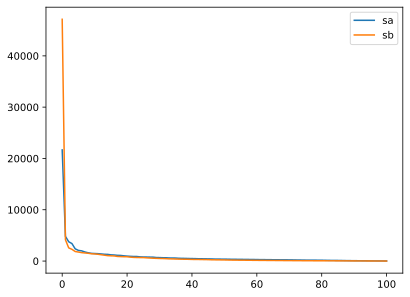

True


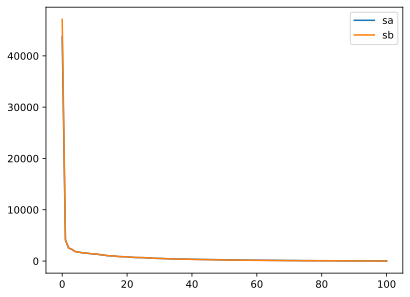

水印强度为: 0.5
用原载体图像解码得到的水印和原水印的相关系数为: 
[[1.        0.9759459]
 [0.9759459 1.       ]]
用附加水印(编码后的)图像解码得到的水印和原水印的相关系数为: 
[[1.         0.99997241]
 [0.99997241 1.        ]]


In [4]:
# 将s序列转化成m*n大小的对角矩阵
def diagonal_mat(m, n, s):
    # assert m * n == len(s), "m*n != len(s)"
    v = np.zeros((m, n))
    for i in range(len(s)):
        v[i, i] = s[i]
    return v


# 不同大小的矩阵相加，默认加在左上角的部分
def add_mat(a, b):
    (ma, na) = a.shape
    (mb, nb) = b.shape
    c = np.zeros((max(ma, mb), max(na, nb)))

    # for i in range(max(ma, mb)):
    #     for j in range(max(na, nb)):
    #         if i < ma and j < na:
    #             c[i, j] += a[i, j]
    #         if i < mb and j < nb:
    #             c[i, j] += b[i, j]

    # 使用 numpy 的切片操作加速计算
    c[:ma, :na] = a
    c[:mb, :nb] += b

    return c


# 截取矩阵中左上角m*n的部分
def extract_mat(a, m, n):
    assert m < a.shape[0] and n < a.shape[1]
    b = a[:m, :n]
    return b


# 对图片a，加水印图片b，通过 svd 生成新的图片的,a,b均为文件名, alpha为水印强度
# (1) 嵌入(编码)过程
def encoding_watermark(a, b, alpha):
    A = cv2.imread(a, cv2.IMREAD_GRAYSCALE)  # 读取原图灰度图
    W = cv2.imread(b, cv2.IMREAD_GRAYSCALE)  # 读取水印灰度图
    print("A shape: {}".format(A.shape))
    print("W shape: {}".format(W.shape))
    u, s, vt = np.linalg.svd(A, full_matrices=True)
    s = diagonal_mat(u.shape[0], vt.shape[0], s)  # 原s是个向量，转化成对角矩阵
    print(np.allclose(A, np.dot(np.dot(u, s), vt)))  # 验证是否相同
    L = add_mat(s, alpha * W)
    u1, s1, v1t = np.linalg.svd(L)
    s1 = diagonal_mat(u1.shape[0], v1t.shape[0], s1)
    aw = np.dot(np.dot(u, s1), vt)  # 添加水印后新的图片
    print("generate aw shape: {}".format(aw.shape))
    # cv2.imwrite("generate.jpg", aw)
    return aw


# 提取(解码)过程,a是原图片的文件名, b是水印图片的文件名, c是嵌入过程中加过水印后的文件名
# return 从c图片提取出来的水印矩阵
def decoding_watermark(a, b, c, alpha):
    A = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    W = cv2.imread(b, cv2.IMREAD_GRAYSCALE)
    u, s, vt = np.linalg.svd(A, full_matrices=True)
    s = diagonal_mat(u.shape[0], vt.shape[0], s)  # 原s是个向量，转化成对角矩阵
    print(np.allclose(A, np.dot(np.dot(u, s), vt)))  # 判断是否相同
    L = add_mat(s, alpha * W)
    u1, s1, v1t = np.linalg.svd(L)
    """
    前面那部分和encoding中的处理一样，获得对应的一些矩阵
    """
    P = cv2.imread(c, cv2.IMREAD_GRAYSCALE)
    up, sp, vpt = np.linalg.svd(P)
    sp = diagonal_mat(up.shape[0], vpt.shape[0], sp)
    F = np.dot(np.dot(u1, sp), v1t)
    WE = (F - s) / alpha
    WE = extract_mat(WE, W.shape[0], W.shape[1])
    return WE


# 计算两个矩阵奇异值序列的相关系数
def cal_similar_of_matrix(a, b):
    ua, sa, vat = np.linalg.svd(a)
    ub, sb, vbt = np.linalg.svd(b)
    # 绘制sa和sb
    plt.plot(sa, label='sa')
    # plt.plot(sb, label='sb')

    # 添加图例
    plt.legend()

    # 显示图形
    plt.show()
    return np.corrcoef(sa, sb)


# 检测部分，c为检测图像文件, a是原图片的文件名, b是水印图片的文件名, alpha是水印强度
# return p提取出来的水印和实际水印的相关系数
def check(a, b, c, alpha):
    WE = decoding_watermark(a, b, c, alpha)
    W = cv2.imread(b, cv2.IMREAD_GRAYSCALE)
    return cal_similar_of_matrix(WE, W)


if __name__ == "__main__":
    # init variables
    alpha = 0.5  # 1.0, 0.5, 0.2
    watermark_img_path = "image/gray_logo.jpg"
    base_img_path = "image/lena512.jpg"
    generated_img_path = "image/encoding0_5.jpg"
    decoding_watermark_path = "image/decoding0_5.jpg"
    # 生成水印加密的图片
    aw = encoding_watermark(base_img_path, watermark_img_path, alpha)
    cv2.imwrite(generated_img_path, aw)
    # 解码得到水印图片
    cv2.imwrite(
        decoding_watermark_path,
        decoding_watermark(
            base_img_path, watermark_img_path, generated_img_path, alpha
        ),
    )
    # 用生成的水印图片解密和两种水印进行对比，计算矩阵相似度
    similarity1 = check(base_img_path, watermark_img_path, base_img_path, alpha)
    similarity2 = check(base_img_path, watermark_img_path, generated_img_path, alpha)
    print("水印强度为: {}".format(alpha))

    # 皮尔逊积矩相关系数
    print(f"用原载体图像解码得到的水印和原水印的相关系数为: \n{similarity1}")
    print(f"用附加水印(编码后的)图像解码得到的水印和原水印的相关系数为: \n{similarity2}")